In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import upsetplot as uplt
import numpy as np
from matplotlib_venn import venn2

import sys
sys.path.append("../")
import utils_ML as uml

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

connection succesfull


In [3]:
GO_description = pd.read_csv("../Atlas_analysis/annotation_files/go_description.txt", sep="\t", index_col="GO_ID")

In [4]:
import json
with open("../Atlas_analysis/ML/GO_C_uniprot_map.json", 'r') as f:
    uniprot_go_compartment = json.load(f)

with open("../Atlas_analysis/ML/GO_F_uniprot_map.json", 'r') as f:
    uniprot_go_function = json.load(f)

with open("../Atlas_analysis/ML/GO_P_uniprot_map.json", 'r') as f:
    uniprot_go_process = json.load(f)

C_GO_prots = list(uniprot_go_compartment.keys())
F_GO_prots = list(uniprot_go_function.keys())
P_GO_prots = list(uniprot_go_process.keys())

In [5]:
meta = pd.read_csv("../Metadata/unified_metadata.csv", index_col="assay_id")
meta["Type"] = meta.pool_id.apply(lambda x: "Whole lysate" if x==0 else "Fraction")
groups = pd.read_csv("../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0] if x in groups.cell_line.unique() else x)

In [6]:
def get_pxd_data(list_PXD, NSAF, meta):
    """
    list_PXD: list of project identifiers for which to return the NSAF data
    NSAF: the protein expression matrix with associated assay_ids
    meta: the associated metadata

    Returns [expression matrix of the list_PXD, associated metadata with matching indices]
    """

    full_table = pd.merge(NSAF.reset_index(), meta.reset_index(), on = "assay_id")
    full_table = full_table[full_table.PXD_accession.isin(list_PXD)]
    full_table.dropna(how='all', axis = 1, inplace = True)
    NSAF, meta = full_table.iloc[:,:-20].set_index("assay_id").copy(), full_table.iloc[:,-20:].reset_index(drop = True).copy()
    meta = meta.set_index(NSAF.index)

    return NSAF, meta

In [7]:
nonPooledNSAF = pd.read_hdf("proteome_nsaf_3.h5")
nonPooledNSAF = pd.pivot_table(nonPooledNSAF, values = "NSAF", index = "assay_id", columns = 'uniprot_id')

pooledNSAF = pd.read_hdf("proteome_nsaf_pooled_3.h5")
pooledNSAF = pd.pivot_table(pooledNSAF, values = "NSAF", index = "assay_id", columns = 'uniprot_id')

nonPooledNSAF = np.log2(nonPooledNSAF)
pooledNSAF = np.log2(pooledNSAF)

In [8]:
HUVEC_pooled, metaPooled = get_pxd_data(["PXD003406","PXD003407"], pooledNSAF, meta)
HUVEC_nonPooled, metaNonPooled = get_pxd_data(["PXD003406","PXD003407"], nonPooledNSAF, meta)
metaPooled.loc[:,["Type"]] = metaPooled.Type.apply(lambda x: "Pooled" if x == "Fraction" else x)

In [9]:
metaNonPooled[metaNonPooled.PXD_accession == "PXD003406"][["filename", "pool_id"]]

,filename,pool_id
assay_id,,
31284,HUVEC_cyt_con_3b,0
31285,HUVEC_cyt_con_6a,0
31286,HUVEC_cyt_con_5b_4,4
31287,HUVEC_cyt_con_2a,0
31288,HUVEC_cyt_con_1a_4,1
31289,HUVEC_cyt_con_3a,0
31290,HUVEC_cyt_con_1b_4,2
31291,HUVEC_cyt_con_5a_1,3
31292,HUVEC_cyt_con_4a,0


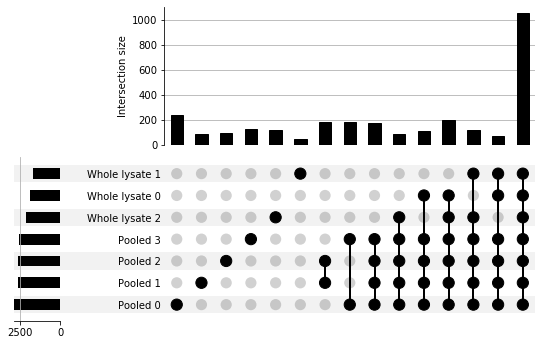

In [188]:
indices_whole_lysates = [31284,31285,31287]
indices_pooled = [31286,31288,31290,31291]

whole_lysate_prots = HUVEC_pooled.loc[indices_whole_lysates].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
pooled_prots = HUVEC_pooled.loc[indices_pooled].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)

whole_lysate_prots = {f"Whole lysate {i}":a for i, a in enumerate(whole_lysate_prots)}
pooled_prots = {f"Pooled {i}":a for i, a in enumerate(pooled_prots)}
whole_lysate_prots.update(pooled_prots)
contents = uplt.from_contents(whole_lysate_prots)
uplt.UpSet(contents, min_subset_size=50)

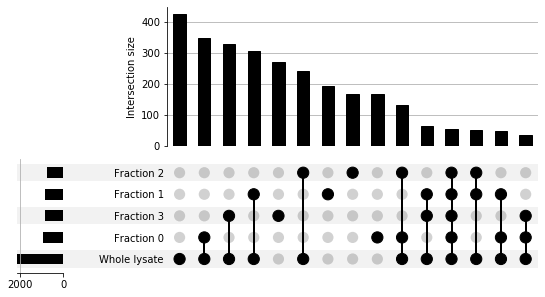

In [37]:
indices = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 3)].index
ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
ided_prots_fraction = {f"Fraction {i}": a for i,a in enumerate(ided_prots)}
ided_prots_fraction.update({"Whole lysate": HUVEC_nonPooled.loc[31287].dropna().index.tolist()})

uplt.UpSet(uplt.from_contents(ided_prots_fraction), min_subset_size=30, sort_by="cardinality")

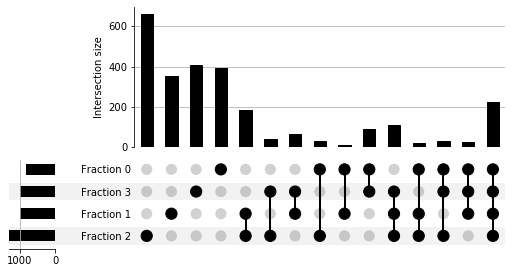

In [10]:
indices = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 1)].index
ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)

contents=uplt.from_contents({f"Fraction {i}": a for i,a in enumerate(ided_prots)})
uplt.UpSet(contents)

In [17]:
for pool_id in [1,2,3,4]:
    print("Sample ", pool_id)
    # Get indices of the fractions belonging to 1 full sample (pool_id represents the complete sample)
    indices = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == pool_id)].index
    # Get the list of proteins identified in each fraction
    ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)

    total_= []
    id_counts = {}
    # for each fraction (list of proteins identified in that fraction)
    for assay in ided_prots:
        total_.append(len(assay))
        # Count the times that protein is identified across fractions
        for prot in assay:
            if prot not in id_counts.keys():
                id_counts[prot] = 1
            else:
                id_counts[prot] += 1

    # Calculate the overlap percentage (number proteins that are identified over all fractions divided by total identified proteins)
    for x in [1,2,3,4]:
        if x == 4:
            overlap_percentage = []
            for i, total in enumerate(total_):
                print("Proteins identified in fraction {}: {} (overlap with all other fractions: {})".format(i, total, list(id_counts.values()).count(x)))
                # Count 4 (identified in all fractions) by total proteins identified in a specific fraction
                overlap_percentage.append(list(id_counts.values()).count(x)/total)
    print(np.mean(overlap_percentage))

Sample  1
Proteins identified in fraction 0: 824 (overlap with all other fractions: 224)
Proteins identified in fraction 1: 998 (overlap with all other fractions: 224)
Proteins identified in fraction 2: 1303 (overlap with all other fractions: 224)
Proteins identified in fraction 3: 997 (overlap with all other fractions: 224)
0.22321963868244854
Sample  2
Proteins identified in fraction 0: 833 (overlap with all other fractions: 237)
Proteins identified in fraction 1: 1013 (overlap with all other fractions: 237)
Proteins identified in fraction 2: 1288 (overlap with all other fractions: 237)
Proteins identified in fraction 3: 981 (overlap with all other fractions: 237)
0.23601719244067532
Sample  3
Proteins identified in fraction 0: 909 (overlap with all other fractions: 61)
Proteins identified in fraction 1: 832 (overlap with all other fractions: 61)
Proteins identified in fraction 2: 750 (overlap with all other fractions: 61)
Proteins identified in fraction 3: 861 (overlap with all othe

In [11]:
for pool_id in [1,2,3,4]:
    # Get indices of the fractions belonging to 1 full sample (pool_id represents the complete sample)
    indices = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == pool_id)].index
    # Get the total unique proteins identified
    ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)

    total_= []
    id_counts = {}
    print(ided_prots)
    for assay in ided_prots:
        total_.append(len(assay))
        for prot in assay:
            if prot not in id_counts.keys():
                id_counts[prot] = 1
            else:
                id_counts[prot] += 1

    for x in [1,2,3,4]:
        if x == 4:
            overlap_percentage = []
            for total in total_:
                
                overlap_percentage.append(list(id_counts.values()).count(x)/total)
    print(np.mean(overlap_percentage))

0.22321963868244854
0.23601719244067532
0.07315130075809109
0.08239376515805483


In [26]:
metaPooled[metaPooled.PXD_accession == "PXD003406"][["filename", "pool_id"]]

,filename,pool_id
assay_id,,
31284,HUVEC_cyt_con_3b,0
31285,HUVEC_cyt_con_6a,0
31286,HUVEC_cyt_con_5b_4,4
31287,HUVEC_cyt_con_2a,0
31288,HUVEC_cyt_con_1a_4,1
31289,HUVEC_cyt_con_3a,0
31290,HUVEC_cyt_con_1b_4,2
31291,HUVEC_cyt_con_5a_1,3
31292,HUVEC_cyt_con_4a,0


In [18]:
indices_large_overlap = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 1)].index
indices_low_overlap = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 3)].index
ided_prots = HUVEC_nonPooled.loc[indices_large_overlap].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
ided_prots_low = HUVEC_nonPooled.loc[indices_low_overlap].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
total_= []
id_counts = {}
id_counts_low = {}
for assay in ided_prots:
    total_.append(len(assay))
    for prot in assay:
        if prot not in id_counts.keys():
            id_counts[prot] = 1
        else:
            id_counts[prot] += 1
for assay in ided_prots_low:
    total_.append(len(assay))
    for prot in assay:
        if prot not in id_counts_low.keys():
            id_counts_low[prot] = 1
        else:
            id_counts_low[prot] += 1

In [ ]:
s3_overlap = [prot for prot, value in id_counts_low.items() if value == 4]
s1_overlap = [prot for prot, value in id_counts.items() if value == 4]

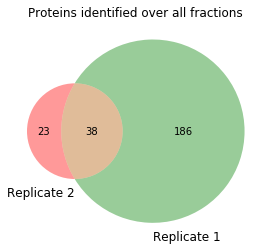

In [28]:
plt.figure(facecolor="white")
plt.title("Proteins identified over all fractions")
venn2((set(s3_overlap), set(s1_overlap)), ("Replicate 2", "Replicate 1"))

In [20]:
s1_overlap_unique = [prot for prot in s1_overlap if prot not in s3_overlap]

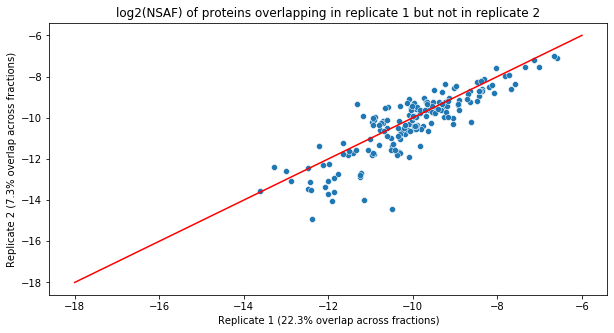

In [46]:
plt.figure(figsize=(10,5))
plt.title("log2(NSAF) of proteins overlapping in replicate 1 but not in replicate 2")
plt.xlabel("Replicate 1 (22.3% overlap across fractions)")
plt.ylabel("Replicate 2 (7.3% overlap across fractions)")
sns.scatterplot(data=HUVEC_pooled.loc[[31288, 31291], s1_overlap_unique].T, x=31288, y = 31291)
plt.plot([-18, -6], [-18, -6], c="red")

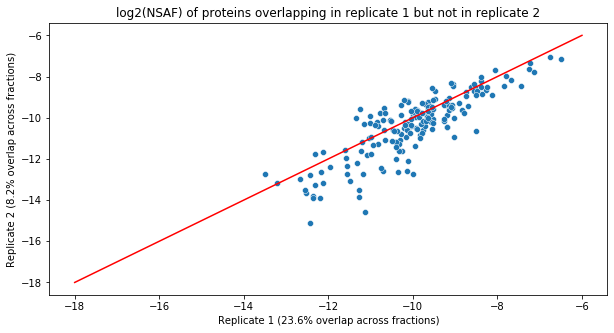

In [47]:
indices_large_overlap = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 2)].index
indices_low_overlap = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 4)].index
ided_prots = HUVEC_nonPooled.loc[indices_large_overlap].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
ided_prots_low = HUVEC_nonPooled.loc[indices_low_overlap].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
total_= []
id_counts = {}
id_counts_low = {}
for assay in ided_prots:
    total_.append(len(assay))
    for prot in assay:
        if prot not in id_counts.keys():
            id_counts[prot] = 1
        else:
            id_counts[prot] += 1
for assay in ided_prots_low:
    total_.append(len(assay))
    for prot in assay:
        if prot not in id_counts_low.keys():
            id_counts_low[prot] = 1
        else:
            id_counts_low[prot] += 1

s3_overlap = [prot for prot, value in id_counts_low.items() if value == 4]
s1_overlap = [prot for prot, value in id_counts.items() if value == 4]
s1_overlap_unique = [prot for prot in s1_overlap if prot not in s3_overlap]
plt.figure(figsize=(10,5))
plt.title("log2(NSAF) of proteins overlapping in replicate 1 but not in replicate 2")
plt.xlabel("Replicate 1 (23.6% overlap across fractions)")
plt.ylabel("Replicate 2 (8.2% overlap across fractions)")
sns.scatterplot(data=HUVEC_pooled.loc[[31286, 31290], s1_overlap_unique].T, x=31290, y = 31286)
plt.plot([-18, -6], [-18, -6], c="red")

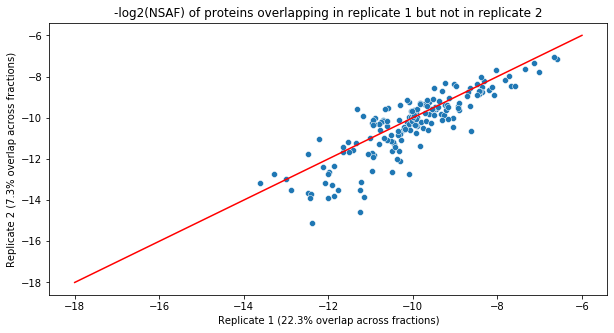

In [44]:
indices_large_overlap = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 1)].index
indices_low_overlap = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 4)].index
ided_prots = HUVEC_nonPooled.loc[indices_large_overlap].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
ided_prots_low = HUVEC_nonPooled.loc[indices_low_overlap].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
total_= []
id_counts = {}
id_counts_low = {}
for assay in ided_prots:
    total_.append(len(assay))
    for prot in assay:
        if prot not in id_counts.keys():
            id_counts[prot] = 1
        else:
            id_counts[prot] += 1
for assay in ided_prots_low:
    total_.append(len(assay))
    for prot in assay:
        if prot not in id_counts_low.keys():
            id_counts_low[prot] = 1
        else:
            id_counts_low[prot] += 1

s3_overlap = [prot for prot, value in id_counts_low.items() if value == 4]
s1_overlap = [prot for prot, value in id_counts.items() if value == 4]
s1_overlap_unique = [prot for prot in s1_overlap if prot not in s3_overlap]
plt.figure(figsize=(10,5))
plt.title("-log2(NSAF) of proteins overlapping in replicate 1 but not in replicate 2")
plt.xlabel("Replicate 1 (22.3% overlap across fractions)")
plt.ylabel("Replicate 2 (7.3% overlap across fractions)")
sns.scatterplot(data=HUVEC_pooled.loc[[31288, 31286], s1_overlap_unique].T, x=31288, y = 31286)
plt.plot([-18, -6], [-18, -6], c="red")

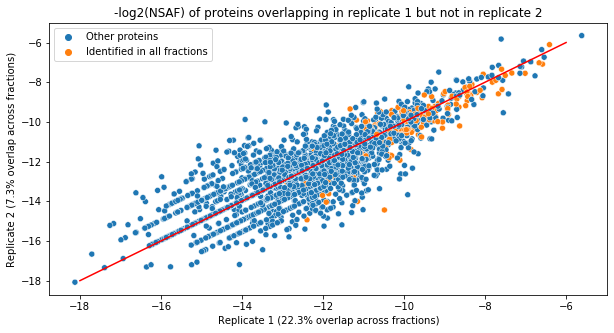

In [32]:
plt.figure(figsize=(10,5))
plt.title("-log2(NSAF) of proteins overlapping in replicate 1 but not in replicate 2")
plt.xlabel("Replicate 1 (22.3% overlap across fractions)")
plt.ylabel("Replicate 2 (7.3% overlap across fractions)")
sns.scatterplot(data=HUVEC_pooled.loc[[31288, 31291]].T, x=31288, y = 31291, hue=["Identified in all fractions" if x in s1_overlap_unique else "Other proteins" for x in HUVEC_pooled.columns])
plt.plot([-18, -6], [-18, -6], c="red")

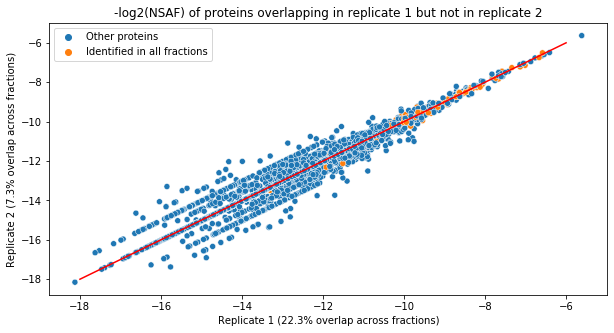

In [45]:
plt.figure(figsize=(10,5))
plt.title("-log2(NSAF) of proteins overlapping in replicate 1 but not in replicate 2")
plt.xlabel("Replicate 1 (22.3% overlap across fractions)")
plt.ylabel("Replicate 2 (7.3% overlap across fractions)")
sns.scatterplot(data=HUVEC_pooled.loc[[31288, 31290]].T, x=31288, y = 31290, hue=["Identified in all fractions" if x in s1_overlap_unique else "Other proteins" for x in HUVEC_pooled.columns])
plt.plot([-18, -6], [-18, -6], c="red")

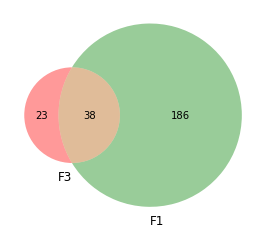

In [25]:
venn2((set(f3_overlap), set(f1_overlap)), ("F3", "F1"))

In [42]:
for pool_id in [1,2,3,4]:
    indices = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003407") & (metaNonPooled.pool_id == pool_id)].index
    ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)

    total_= []
    id_counts = {}
    for assay in ided_prots:
        total_.append(len(assay))
        for prot in assay:
            if prot not in id_counts.keys():
                id_counts[prot] = 1
            else:
                id_counts[prot] += 1

    for x in [1,2,3,4]:
        if x == 4:
            overlap_percentage = []
            for total in total_:
                overlap_percentage.append(list(id_counts.values()).count(x)/total)
    print(np.mean(overlap_percentage))

0.19843410299332936
0.2038841849789145
0.07630616862545236
0.07603134578788943


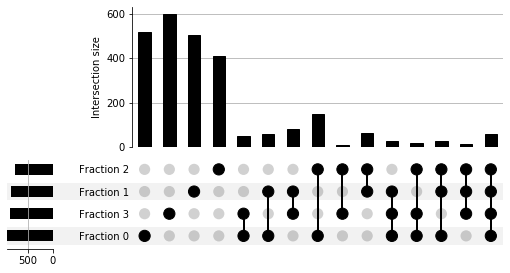

In [36]:
indices = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 3)].index
ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)

contents=uplt.from_contents({f"Fraction {i}": a for i,a in enumerate(ided_prots)})
uplt.UpSet(contents)

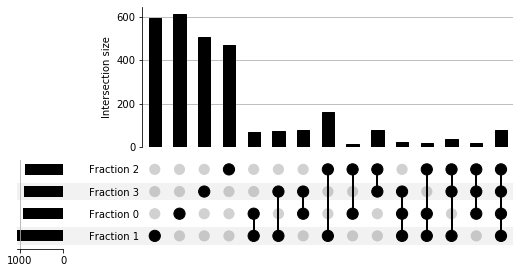

In [37]:
indices = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 4)].index
ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)

contents=uplt.from_contents({f"Fraction {i}": a for i,a in enumerate(ided_prots)})
uplt.UpSet(contents)

In [21]:
GO_count = {}
for prot in list(set(ided_prots.iloc[0]).intersection(set(ided_prots.iloc[1])).intersection(set(ided_prots.iloc[2])).intersection(set(ided_prots.iloc[3]))):
    GOs = uniprot_go_compartment[prot]
    for go in GOs:
        if go not in GO_count.keys():
            GO_count[go] = 1
        else:
            GO_count[go] += 1

In [13]:
uniprot_description.loc[list(set(ided_prots.iloc[0]).intersection(set(ided_prots.iloc[1])).intersection(set(ided_prots.iloc[2])).intersection(set(ided_prots.iloc[3])))]

,description
uniprot_id,
P30050,60S ribosomal protein L12
P26038,Moesin
Q16531,DNA damage-binding protein 1
Q14974,Importin subunit beta-1
P27797,Calreticulin
...,...
P38646,"Stress-70 protein, mitochondrial"
P35221,Catenin alpha-1
Q14566,DNA replication licensing factor MCM6


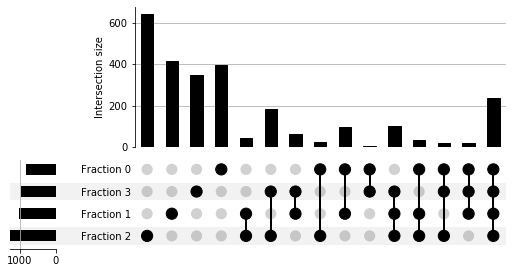

In [65]:
indices = metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 2)].index
ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
contents=uplt.from_contents({f"Fraction {i}": a for i,a in enumerate(ided_prots)})
uplt.UpSet(contents) 

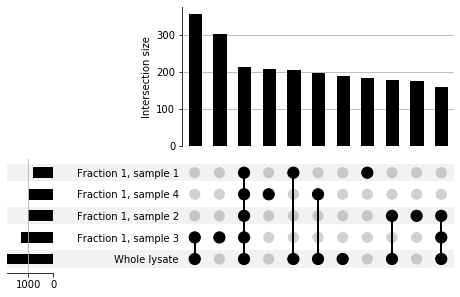

In [66]:
indices = [31284] + list(metaNonPooled[(metaNonPooled.PXD_accession == "PXD003406") & (metaNonPooled.pool_id == 1)].index)
ided_prots = HUVEC_nonPooled.loc[indices].dropna(how="all", axis=1).notna().apply(lambda x: x.index[x].tolist(), axis=1)
fraction_and_WL = {f"Fraction 1, sample {i}": a for i,a in enumerate(ided_prots)}
fraction_and_WL["Whole lysate"]=fraction_and_WL.pop("Fraction 1, sample 0")
contents=uplt.from_contents(fraction_and_WL)
uplt.UpSet(contents, sort_by ="cardinality", min_subset_size = 100) 

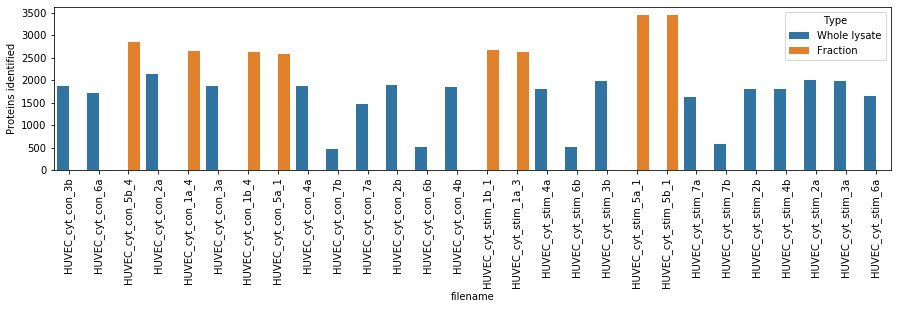

In [74]:
plt.figure(figsize=(15,3))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=metaPooled["filename"], y=HUVEC_pooled.notna().sum(axis=1).tolist(), hue = metaPooled["Type"])

In [11]:
non_pooled_sample_indeces = metaNonPooled[metaNonPooled.Type == "Fraction"].index.tolist()
combined_HUVEC = pd.concat([HUVEC_nonPooled.loc[non_pooled_sample_indeces, :], HUVEC_pooled])
combined_meta = pd.concat([metaNonPooled[metaNonPooled.Type == "Fraction"], metaPooled])

combined_HUVEC.sort_index(inplace=True)
combined_meta.sort_index(inplace=True)

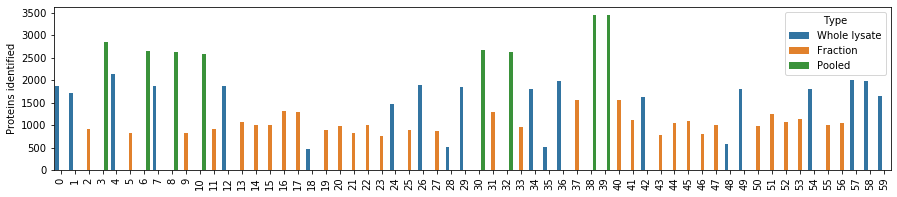

In [91]:
plt.figure(figsize=(15,3))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=list(range(len(combined_HUVEC))), y=combined_HUVEC.notna().sum(axis=1).tolist(), hue = combined_meta["Type"].reset_index(drop=True))

In [12]:
cb = pd.DataFrame(MinMaxScaler().fit_transform(combined_HUVEC),index=combined_HUVEC.index, columns=combined_HUVEC.columns)
cb = uml.FilterByOccurence(.5).fit_transform(cb).fillna(0)

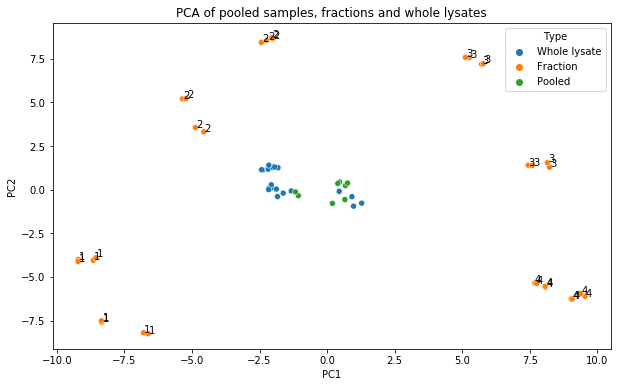

In [20]:
results = PCA(n_components=2).fit_transform(cb)
plt.figure(figsize=(10,6))
plt.title("PCA of pooled samples, fractions and whole lysates")
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"], index=cb.index), x= "PC1", y = "PC2", hue = combined_meta["Type"])
for i in range(0, results.shape[0]):
    if combined_meta.iloc[i]["Type"] in ["Pooled", "Whole lysate"]:
        continue
    plt.text(results[i][0]+.001*i, results[i][1]+.001*i, 
            pd.merge(cb.reset_index(), meta.reset_index(), on = "assay_id").iloc[i,:].filename[-1])

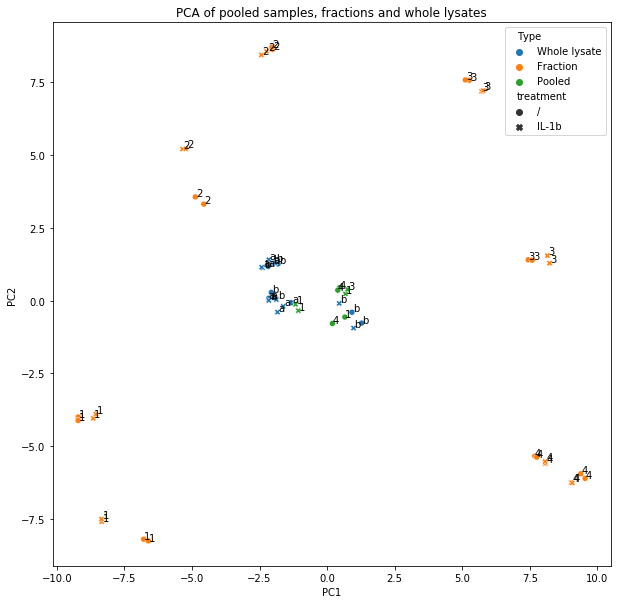

In [113]:
results = PCA(n_components=2).fit_transform(cb)
plt.figure(figsize=(10,10))
plt.title("PCA of pooled samples, fractions and whole lysates")
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"], index=cb.index), x= "PC1", y = "PC2", hue = combined_meta["Type"], style=combined_meta['treatment'])
for i in range(0, results.shape[0]):
    plt.text(results[i][0]+.001*i, results[i][1]+.001*i, 
            pd.merge(cb.reset_index(), meta.reset_index(), on = "assay_id").iloc[i,:].filename[-1])

---

# Breast cell lines

In [132]:
breast_pooled.index

Int64Index([31254, 31255, 31256, 31257, 31258, 31259, 31260, 31261, 31262,
            31263,
            ...
            36533, 36538, 36543, 36548, 36553, 36558, 36563, 36568, 36573,
            36578],
           dtype='int64', name='assay_id', length=106)

In [134]:
pd.merge(breast_pooled, meta, on = "assay_id")["Type"]

assay_id
31254    Whole lysate
31255    Whole lysate
31256    Whole lysate
31257    Whole lysate
31258    Whole lysate
             ...     
36558        Fraction
36563        Fraction
36568        Fraction
36573        Fraction
36578        Fraction
Name: Type, Length: 106, dtype: object

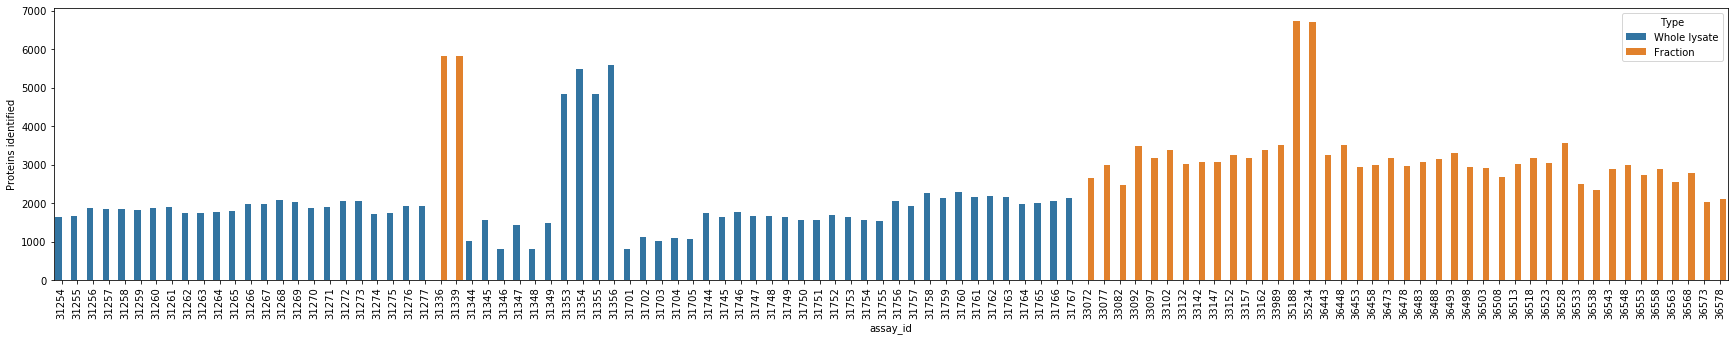

In [133]:
breast_unpooled = nonPooledNSAF[nonPooledNSAF.index.isin(meta[meta.Group=="Ductal_breast"].index)]
breast_pooled = pooledNSAF[pooledNSAF.index.isin(meta[meta.Group=="Ductal_breast"].index)]

plt.figure(figsize=(30,5))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=breast_pooled.index, y=breast_pooled.notna().sum(axis=1), hue = pd.merge(breast_pooled, meta, on = "assay_id")["Type"])

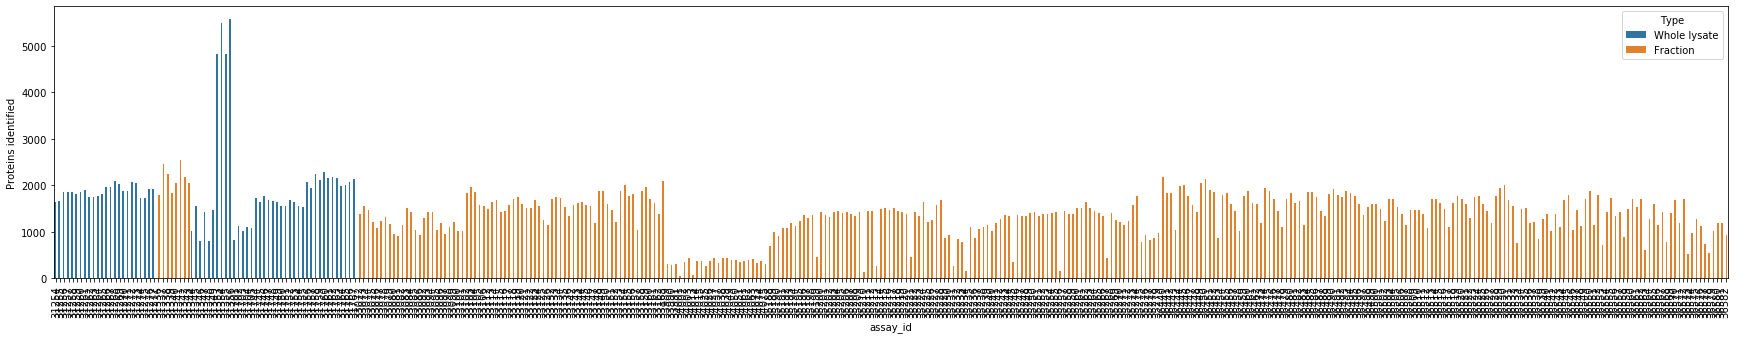

In [136]:
plt.figure(figsize=(30,5))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=breast_unpooled.index, y=breast_unpooled.notna().sum(axis=1), hue = pd.merge(breast_unpooled, meta, on = "assay_id")["Type"])

In [139]:
meta[meta.Group == "Ductal_breast"].PXD_accession.unique()

array(['PXD008719', 'PXD001352', 'PXD007543', 'PXD005940', 'PXD004452',
       'PXD001327', 'PXD002057', 'PXD009442', 'PXD008222'], dtype=object)

In [156]:
DB_pooled, metaPooled = get_pxd_data(['PXD008719', 'PXD001352', 'PXD007543', 'PXD005940', 'PXD004452',
       'PXD001327', 'PXD002057', 'PXD009442', 'PXD008222'], pooledNSAF, meta)

DB_pooled = DB_pooled.loc[metaPooled[metaPooled.Group == "Ductal_breast"].index]
metaPooled = metaPooled.loc[metaPooled[metaPooled.Group == "Ductal_breast"].index]

DB_nonPooled, metaNonPooled = get_pxd_data(['PXD008719', 'PXD001352', 'PXD007543', 'PXD005940', 'PXD004452',
       'PXD001327', 'PXD002057', 'PXD009442', 'PXD008222'], nonPooledNSAF, meta)

DB_nonPooled = DB_nonPooled.loc[metaNonPooled[metaNonPooled.Group == "Ductal_breast"].index]
metaNonPooled = metaNonPooled.loc[metaNonPooled[metaNonPooled.Group == "Ductal_breast"].index]

metaPooled.loc[:,["Type"]] = metaPooled.Type.apply(lambda x: "Pooled" if x == "Fraction" else x)

In [167]:
non_pooled_sample_indeces = metaNonPooled[metaNonPooled.Type == "Fraction"].index.tolist()
combined_DB = pd.concat([DB_nonPooled.loc[non_pooled_sample_indeces, :], DB_pooled])
combined_meta = pd.concat([metaNonPooled[metaNonPooled.Type == "Fraction"], metaPooled])

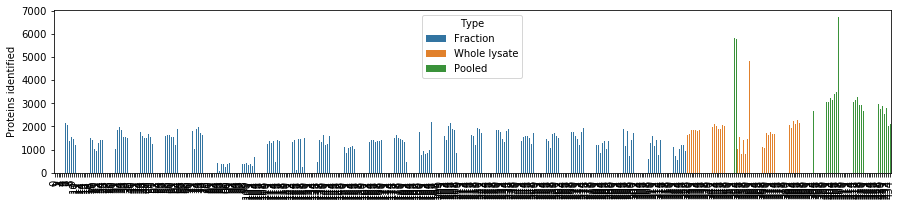

In [158]:
plt.figure(figsize=(15,3))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=list(range(len(combined_DB))), y=combined_DB.notna().sum(axis=1).tolist(), hue = combined_meta["Type"])

In [191]:
cb = pd.DataFrame(MinMaxScaler().fit_transform(combined_DB),index=combined_DB.index, columns=combined_DB.columns)
cb = uml.FilterByOccurence(.5).fit_transform(cb).fillna(0)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


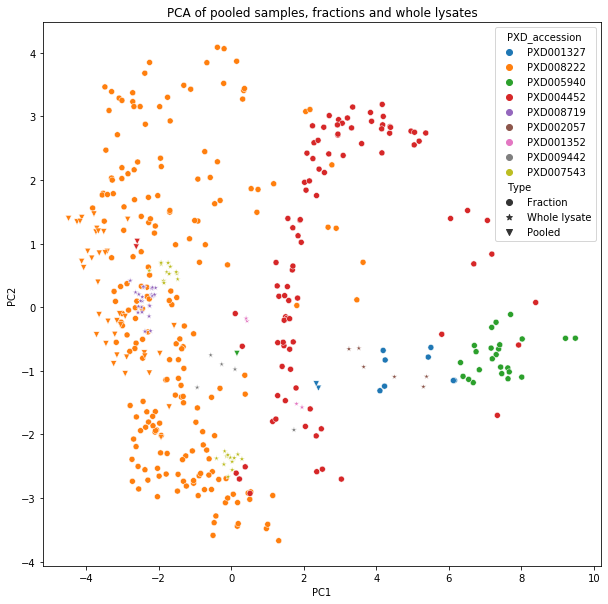

In [192]:
results = PCA(n_components=2).fit_transform(cb)
#results = TSNE(perplexity=20).fit_transform(cb)

plt.figure(figsize=(10,10))
plt.title("PCA of pooled samples, fractions and whole lysates")
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"], index=cb.index), x= "PC1", y = "PC2", hue = combined_meta["PXD_accession"], style=combined_meta['Type'], markers=["o", "*", "v"])

In [196]:
cb = pd.DataFrame(MinMaxScaler().fit_transform(DB_pooled),index=DB_pooled.index, columns=DB_pooled.columns)
cb = uml.FilterByOccurence(.5).fit_transform(cb).fillna(0)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


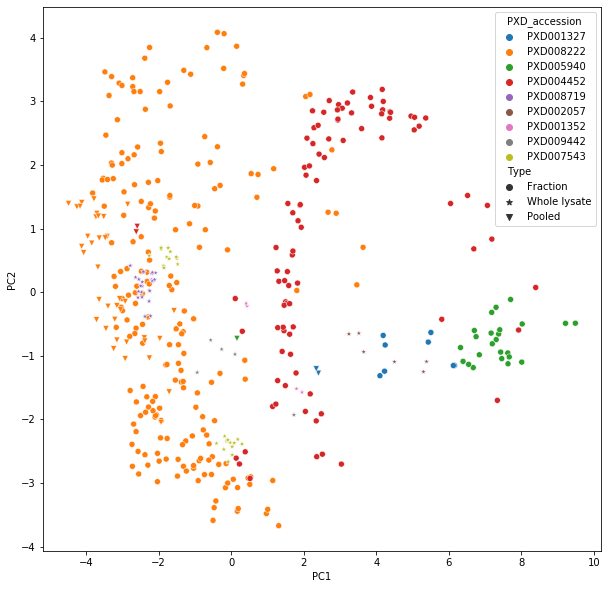

In [194]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"], index=cb.index), x= "PC1", y = "PC2", hue = combined_meta["PXD_accession"], style=combined_meta['Type'],
                markers=["o", "*", "v"])

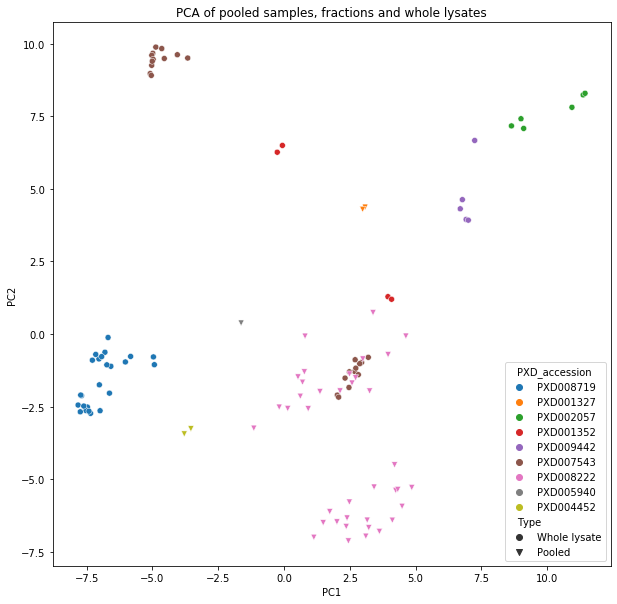

In [198]:
results = PCA(n_components=2).fit_transform(cb)
#results = TSNE(perplexity=20).fit_transform(cb)

plt.figure(figsize=(10,10))
plt.title("PCA of pooled samples, fractions and whole lysates")
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"], index=cb.index), x= "PC1", y = "PC2", hue = metaPooled["PXD_accession"], style=metaPooled['Type'], markers=["o", "v"])

---